This notebook uses the existing sales data from existing_products.csv to predict sales volume on new_products.csv

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import r2_score,mean_squared_error
import numpy as np

In [2]:
existing_products = pd.read_csv("existingProductAttributes.csv")
new_products = pd.read_csv("newProductAttributes.csv")

In [3]:
# EDA on existing products
existing_products.describe()

,Product #,Price,5 Star Reviews,4 Star Reviews,3 Star Reviews,2 Star Reviews,1 Star Reviews,Positive Service Review,Negative Service Review,Would consumer recommend product,Best Sellers Rank,Shipping Weight (lbs),Product Depth,Product Width,Product Height,Profit margin,Volume
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,65.000000,80.000000,80.000000,80.000000,80.000000,80.00000,80.000000
mean,142.550000,247.251125,176.250000,40.200000,14.787500,13.787500,37.675000,51.750000,6.225000,0.745000,1126.307692,9.668125,14.425250,7.819000,6.258625,0.15450,705.000000
std,26.732572,339.574925,379.193698,70.741891,30.963717,45.924455,186.718483,104.471606,14.304974,0.197388,3261.130095,15.207573,34.930846,6.814665,6.888852,0.11639,1516.774793
min,101.000000,3.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,1.000000,0.010000,0.000000,0.000000,0.000000,0.05000,0.000000
25%,120.750000,52.665000,10.000000,2.750000,2.000000,1.000000,2.000000,2.000000,1.000000,0.700000,7.000000,0.512500,4.775000,1.750000,0.400000,0.05000,40.000000
50%,140.500000,132.720000,50.000000,22.000000,7.000000,3.000000,8.500000,5.500000,3.000000,0.800000,27.000000,2.100000,7.950000,6.800000,3.950000,0.12000,200.000000
75%,160.250000,352.490000,306.500000,33.000000,11.250000,7.000000,15.250000,42.000000,6.250000,0.900000,281.000000,11.205000,15.025000,11.275000,10.300000,0.20000,1226.000000
max,200.000000,2249.990000,2801.000000,431.000000,162.000000,370.000000,1654.000000,536.000000,112.000000,1.000000,17502.000000,63.000000,300.000000,31.750000,25.800000,0.40000,11204.000000


In [4]:
# modifying new sales file columns to match existing sales file
new_products.rename(columns={'\'Product Type\'': 'Product Type', '\'Product #\'': 'Product #', 
                             '\'5 Star Reviews\'': '5 Star Reviews', '\'4 Star Reviews\'': '4 Star Reviews',
    '\'3 Star Reviews\'': '3 Star Reviews', '\'2 Star Reviews\'': '2 Star Reviews','\'1 Star Reviews\'': '1 Star Reviews',
      '\'Positive Service Review\'': 'Positive Service Review', '\'Negative Service Review\'': 'Negative Service Review',
        '\'Best Sellers Rank\'': 'Best Sellers Rank', '\'Shipping Weight (lbs)\'': 'Shipping Weight (lbs)',
          '\'Product Depth\'': 'Product Depth', '\'Product Width\'': 'Product Width',
       '\'Product Height\'': 'Product Height', '\'Profit margin\'': 'Profit margin',
         '\'Would consumer recommend product\'': 'Would consumer recommend product'                    
                            }, inplace=True)

In [5]:
# Best sellers rank has na's. Removing to clean. Another alternative is dropna
del existing_products['Best Sellers Rank']
del new_products['Best Sellers Rank']

In [6]:
corr = existing_products.corr()

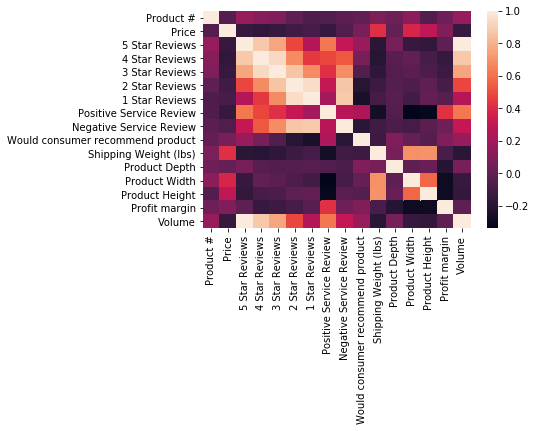

In [7]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [8]:
existing_products.corr().unstack().sort_values(ascending = False).drop_duplicates()

Volume                   Volume                   1.000000
1 Star Reviews           2 Star Reviews           0.951913
4 Star Reviews           3 Star Reviews           0.937214
Negative Service Review  1 Star Reviews           0.884728
5 Star Reviews           4 Star Reviews           0.879006
                                                    ...   
Positive Service Review  Shipping Weight (lbs)   -0.270739
Product Height           Profit margin           -0.288106
Profit margin            Product Width           -0.291436
Positive Service Review  Product Height          -0.314294
                         Product Width           -0.339094
Length: 106, dtype: float64

In [9]:
# feature engineering - remove features that have correlation greater than 90% with each other
del existing_products['1 Star Reviews']
del existing_products['4 Star Reviews']

In [10]:
# make same changes to the data on which we will make predictions
del new_products['1 Star Reviews']
del new_products['4 Star Reviews']

In [11]:
# Since product type is categorical, and we want to predict the numerical sales volume via regression we need to dummify product type
existing_products = pd.get_dummies(existing_products, columns=["Product Type"])
new_products = pd.get_dummies(new_products, columns=["Product Type"])

In [13]:
cols_e = existing_products.columns
new_products = new_products.reindex(columns=cols_e)

In [14]:
feature_cols = ['Product #', 'Price', '5 Star Reviews', '3 Star Reviews',
       '2 Star Reviews', 'Positive Service Review', 'Negative Service Review',
       'Would consumer recommend product', 'Shipping Weight (lbs)',
       'Product Depth', 'Product Width', 'Product Height', 'Profit margin',
       'Product Type_Accessories', 'Product Type_Display',
       'Product Type_Extended Warranty', 'Product Type_Game Console',
       'Product Type_Laptop', 'Product Type_Netbook', 'Product Type_PC',
       'Product Type_Printer', 'Product Type_Printer Supplies',
       'Product Type_Smartphone', 'Product Type_Software',
       'Product Type_Tablet']
X = existing_products[feature_cols] # Features
y = existing_products['Volume'] # Target variable

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [16]:
# Create SVR model object
svr = SVR()
# Train model
svr = svr.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = svr.predict(X_test)

In [17]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

RMSE:  805.5794568300819


In [18]:
print("R2 score : %.2f" % r2_score(y_test,y_pred))

R2 score : -0.68


In [19]:
# Create Random forest model object
rf = RandomForestRegressor()
# Train model
rf = rf.fit(X_train,y_train)
#Predict the response for test dataset
y_pred_rf = rf.predict(X_test)

In [20]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print("RMSE: ", rmse_rf)

RMSE:  377.0806564472204


In [21]:
print("R2 score : %.2f" % r2_score(y_test,y_pred_rf))

R2 score : 0.63


In [22]:
X_new_products = new_products[feature_cols] # Features
X_new_products = X_new_products.fillna(0)

In [23]:
# get predictions from better model
y_pred_new_products = rf.predict(X_new_products)

In [24]:
new_products['Predicted_Volume'] = y_pred_new_products

In [25]:
new_products.to_csv("New_Products_Sales_Predictions.csv")